In [ ]:
!pip install dynamax

Installing Dynamax...
Dynamax installed successfully!
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


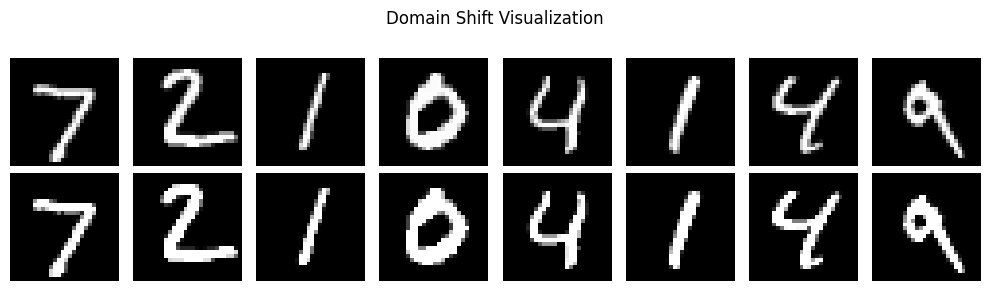


INITIALIZING SIMPLE TRANSFORMER

Training baseline Transformer...
Epoch 1/30: train_loss=2.4460 test_acc=0.2062
Epoch 2/30: train_loss=2.3397 test_acc=0.2792
Epoch 4/30: train_loss=2.1409 test_acc=0.2857
Epoch 6/30: train_loss=1.9555 test_acc=0.3153
Epoch 8/30: train_loss=1.8943 test_acc=0.3729
Epoch 10/30: train_loss=1.7469 test_acc=0.4035
Epoch 12/30: train_loss=1.6222 test_acc=0.4617
Epoch 14/30: train_loss=1.6520 test_acc=0.4749
Epoch 16/30: train_loss=1.5989 test_acc=0.5027
Epoch 18/30: train_loss=1.5936 test_acc=0.5093
Epoch 20/30: train_loss=1.5213 test_acc=0.5264
Epoch 22/30: train_loss=1.3408 test_acc=0.5269
Epoch 24/30: train_loss=1.3573 test_acc=0.5453
Epoch 26/30: train_loss=1.3251 test_acc=0.5660
Epoch 28/30: train_loss=1.3850 test_acc=0.5601
Epoch 30/30: train_loss=1.2514 test_acc=0.5862

Baseline accuracy (original): 0.5862
Baseline accuracy (shifted):  0.5797
Performance drop: 0.0065


SELECTIVE ADAPTATION (FC LAYER ONLY)
Adapt Epoch 1/5: loss=1.2694 acc=0.5823
Adapt E

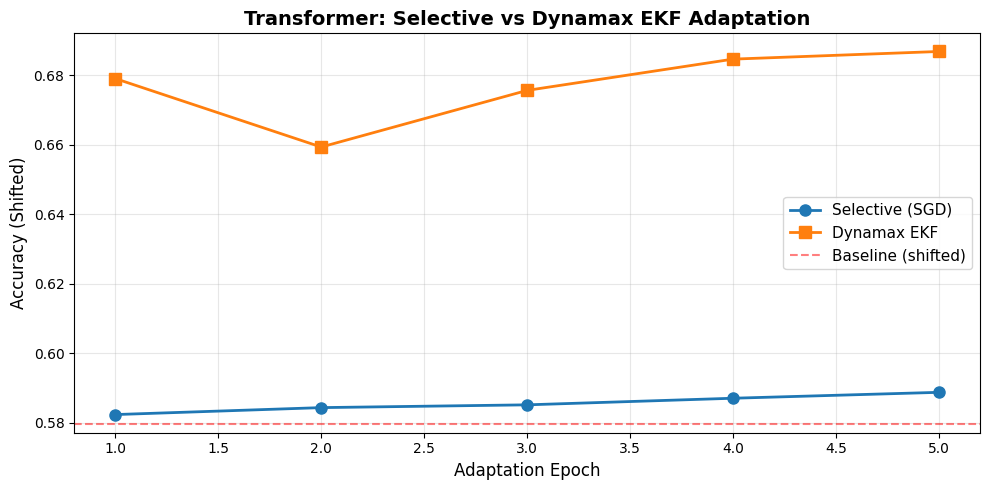

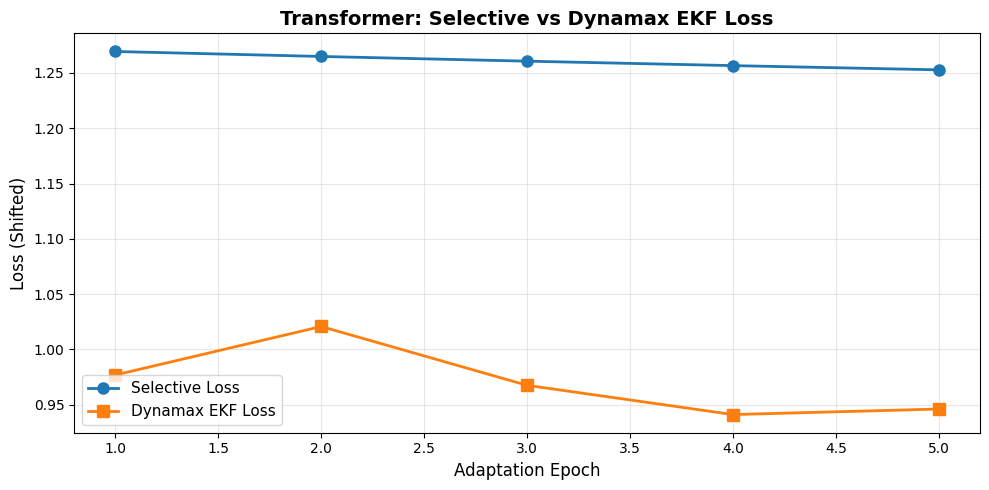


Parameter L2 change (Baseline → Selective):    0.137846
Parameter L2 change (Baseline → Dynamax EKF):  45.322433



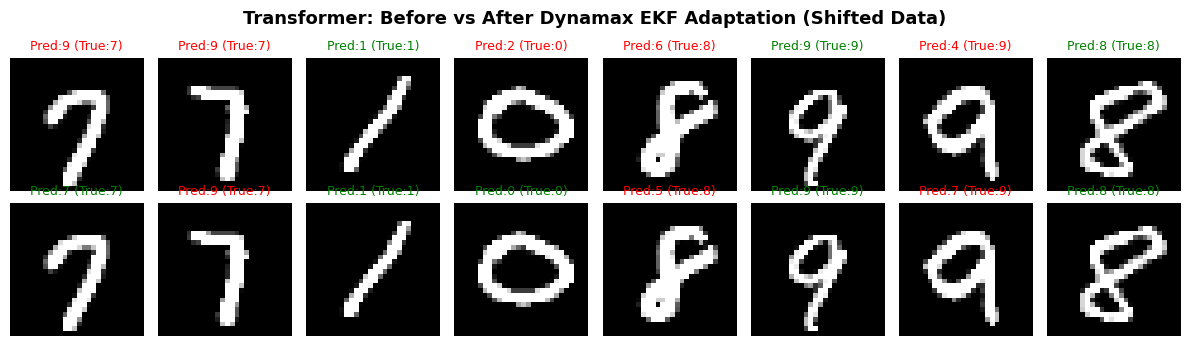


SUMMARY
Architecture: Simple Transformer (patch_size=7, embed_dim=64, 2 blocks)
Baseline accuracy (original): 0.5862
Baseline accuracy (shifted):  0.5797
Selective final accuracy:     0.5887
Dynamax EKF final accuracy:   0.6868



In [2]:
# =====================================
# 0. Install Dynamax
# =====================================
import subprocess
import sys

try:
    import dynamax
    print("Dynamax already installed!")
except ImportError:
    print("Installing Dynamax...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "dynamax"])
    print("Dynamax installed successfully!")

# =====================================
# 1. Setup and Data Preparation
# =====================================
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from flax import nnx
from tensorflow.keras.datasets import mnist
import copy
from jax.flatten_util import ravel_pytree
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
from dynamax.generalized_gaussian_ssm.inference import conditional_moments_gaussian_filter, EKFIntegrals

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

# Create domain shift: contrast and brightness
X_test_shifted = np.clip(((X_test - 0.5) * 1.8 + 0.5) + 0.4, 0, 1)
y_test_shifted = y_test

# Visualize domain shift
fig, axes = plt.subplots(2, 8, figsize=(10, 3))
for i in range(8):
    axes[0, i].imshow(X_test[i], cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(X_test_shifted[i], cmap="gray")
    axes[1, i].axis("off")
axes[0, 0].set_ylabel("Original", rotation=0, labelpad=40)
axes[1, 0].set_ylabel("Shifted", rotation=0, labelpad=40)
plt.suptitle("Domain Shift Visualization")
plt.tight_layout()
plt.show()

# =====================================
# 2. Simple Transformer Components
# =====================================

class SimpleAttention(nnx.Module):
    """Single-head self-attention"""
    def __init__(self, embed_dim, *, rngs: nnx.Rngs):
        self.embed_dim = embed_dim
        self.query = nnx.Linear(embed_dim, embed_dim, rngs=rngs)
        self.key = nnx.Linear(embed_dim, embed_dim, rngs=rngs)
        self.value = nnx.Linear(embed_dim, embed_dim, rngs=rngs)

    def __call__(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = jnp.matmul(Q, K.transpose(0, 2, 1)) / jnp.sqrt(self.embed_dim)
        attn_weights = jax.nn.softmax(scores, axis=-1)
        output = jnp.matmul(attn_weights, V)
        return output


class TransformerBlock(nnx.Module):
    """Single transformer block with attention + FFN"""
    def __init__(self, embed_dim, ffn_dim, *, rngs: nnx.Rngs):
        self.attention = SimpleAttention(embed_dim, rngs=rngs)
        self.norm1 = nnx.LayerNorm(embed_dim, rngs=rngs)
        self.ffn1 = nnx.Linear(embed_dim, ffn_dim, rngs=rngs)
        self.ffn2 = nnx.Linear(ffn_dim, embed_dim, rngs=rngs)
        self.norm2 = nnx.LayerNorm(embed_dim, rngs=rngs)

    def __call__(self, x):
        attn_out = self.attention(x)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn2(jax.nn.relu(self.ffn1(x)))
        x = self.norm2(x + ffn_out)
        return x


class SimpleTransformer(nnx.Module):
    """Simple Transformer for MNIST classification"""
    def __init__(self, patch_size, embed_dim, num_blocks, num_classes, *, rngs: nnx.Rngs):
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embed = nnx.Linear(patch_size * patch_size, embed_dim, rngs=rngs)
        self.blocks = [TransformerBlock(embed_dim, embed_dim * 2, rngs=rngs)
                      for _ in range(num_blocks)]
        self.fc = nnx.Linear(embed_dim, num_classes, rngs=rngs)

    def __call__(self, x):
        batch_size = x.shape[0]
        patches = jnp.reshape(x, (batch_size, 28 // self.patch_size, self.patch_size,
                                  28 // self.patch_size, self.patch_size))
        patches = jnp.transpose(patches, (0, 1, 3, 2, 4))
        patches = jnp.reshape(patches, (batch_size, -1, self.patch_size * self.patch_size))
        x = self.patch_embed(patches)
        for block in self.blocks:
            x = block(x)
        x = jnp.mean(x, axis=1)
        return self.fc(x)


# =====================================
# 3. Loss, Accuracy, and Utility
# =====================================

def cross_entropy(logits, labels):
    y = jax.nn.one_hot(labels, 10)
    return -jnp.mean(jnp.sum(y * jax.nn.log_softmax(logits), axis=-1))


def accuracy(logits, labels):
    return jnp.mean(jnp.argmax(logits, -1) == labels)


def eval_batch(model, x, y):
    logits = model(x)
    return cross_entropy(logits, y), accuracy(logits, y)


# =====================================
# 4. Baseline Training
# =====================================

print("\n" + "="*50)
print("INITIALIZING SIMPLE TRANSFORMER")
print("="*50)

rngs = nnx.Rngs(0)
model = SimpleTransformer(
    patch_size=7,
    embed_dim=64,
    num_blocks=2,
    num_classes=10,
    rngs=rngs
)

optimizer = nnx.Optimizer(model, optax.adam(2e-3))

epochs = 30
batch_size = 512
train_losses, test_accs = [], []

print("\nTraining baseline Transformer...")
for ep in range(epochs):
    idx = np.random.choice(len(X_train), batch_size, replace=False)
    Xb, yb = X_train[idx], y_train[idx]

    def loss_fn(model):
        logits = model(Xb)
        loss = cross_entropy(logits, yb)
        return loss, logits

    (loss_value, _), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model)
    optimizer.update(grads)

    if (ep + 1) % 2 == 0 or ep == 0:
        l, a = eval_batch(model, X_test, y_test)
        train_losses.append(float(loss_value))
        test_accs.append(float(a))
        print(f"Epoch {ep+1}/{epochs}: train_loss={float(loss_value):.4f} test_acc={float(a):.4f}")

baseline_model = copy.deepcopy(model)
l_shift, a_shift = eval_batch(model, X_test_shifted, y_test_shifted)
print(f"\n{'='*50}")
print(f"Baseline accuracy (original): {test_accs[-1]:.4f}")
print(f"Baseline accuracy (shifted):  {a_shift:.4f}")
print(f"Performance drop: {(test_accs[-1] - a_shift):.4f}")
print(f"{'='*50}\n")

# =====================================
# 5. Selective Adaptation (Head only)
# =====================================

print("\n" + "="*50)
print("SELECTIVE ADAPTATION (FC LAYER ONLY)")
print("="*50)

selective_model = copy.deepcopy(baseline_model)
sel_opt = nnx.Optimizer(selective_model.fc, optax.adam(1e-3))
sel_losses, sel_accs = [], []
num_adapt_epochs = 5

for ep in range(num_adapt_epochs):
    Xb, yb = X_test_shifted, y_test_shifted

    def loss_fn(fc):
        batch_size = Xb.shape[0]
        patches = jnp.reshape(Xb, (batch_size, 28 // selective_model.patch_size,
                                   selective_model.patch_size,
                                   28 // selective_model.patch_size,
                                   selective_model.patch_size))
        patches = jnp.transpose(patches, (0, 1, 3, 2, 4))
        patches = jnp.reshape(patches, (batch_size, -1,
                                       selective_model.patch_size * selective_model.patch_size))
        x = selective_model.patch_embed(patches)
        for block in selective_model.blocks:
            x = block(x)
        x = jnp.mean(x, axis=1)
        x = jax.lax.stop_gradient(x)
        logits = fc(x)
        loss = cross_entropy(logits, yb)
        return loss, logits

    (loss_value, _), grads = nnx.value_and_grad(loss_fn, has_aux=True)(selective_model.fc)
    sel_opt.update(grads)

    l, a = eval_batch(selective_model, X_test_shifted, y_test_shifted)
    sel_losses.append(float(l))
    sel_accs.append(float(a))
    print(f"Adapt Epoch {ep+1}/{num_adapt_epochs}: loss={float(l):.4f} acc={float(a):.4f}")

print(f"\nSelective adaptation final accuracy: {sel_accs[-1]:.4f}")
print(f"Improvement: {(sel_accs[-1] - a_shift):.4f}")

# =====================================
# 6. Dynamax EKF Adaptation
# =====================================

print("\n" + "="*50)
print("DYNAMAX EKF-BASED ADAPTATION (FC LAYER)")
print("="*50)

dynamax_ekf_model = copy.deepcopy(baseline_model)

# Extract FC layer parameters and create flattening utilities
fc_params = nnx.state(dynamax_ekf_model.fc)
flat_params, unflatten_fn = ravel_pytree(fc_params)
state_dim = flat_params.size

# Function to extract features from frozen transformer
def extract_features(model, X):
    batch_size = X.shape[0]
    patches = jnp.reshape(X, (batch_size, 28 // model.patch_size,
                             model.patch_size,
                             28 // model.patch_size,
                             model.patch_size))
    patches = jnp.transpose(patches, (0, 1, 3, 2, 4))
    patches = jnp.reshape(patches, (batch_size, -1,
                                   model.patch_size * model.patch_size))
    x = model.patch_embed(patches)
    for block in model.blocks:
        x = block(x)
    x = jnp.mean(x, axis=1)
    return x

# FC layer forward function using flat parameters
def fc_forward(flat_params_val, features):
    """Apply FC layer with flattened parameters"""
    unflattened = unflatten_fn(flat_params_val)
    # Manually apply linear layer: y = x @ W + b
    W = unflattened['kernel'].value
    b = unflattened['bias'].value
    return features @ W + b

# Dynamax EKF parameters
prior_var = 0.1
dynamic_sigma = 1e-4

initial_mean = flat_params
initial_covariance = jnp.eye(state_dim) * prior_var

# State transition: identity (parameters don't change except through updates)
dynamics_function = lambda w, x: w
dynamics_covariance = jnp.eye(state_dim) * dynamic_sigma

# Emission functions for cross-entropy loss with softmax
def emission_mean_function(w, x):
    """Expected observation: softmax probabilities"""
    logits = fc_forward(w, x)
    return jax.nn.softmax(logits)

def emission_cov_function(w, x):
    """Observation covariance (using softmax variance approximation)"""
    probs = emission_mean_function(w, x)
    # Diagonal approximation of softmax covariance
    return jnp.diag(probs * (1 - probs)) + 1e-5 * jnp.eye(10)

# Create Dynamax EKF parameters
ekf_params = ParamsGGSSM(
    initial_mean=initial_mean,
    initial_covariance=initial_covariance,
    dynamics_function=dynamics_function,
    dynamics_covariance=dynamics_covariance,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function
)

dynamax_accs, dynamax_losses = [], []

print("Running Dynamax EKF filter...")
# Extract features once for all epochs
features = extract_features(dynamax_ekf_model, X_test_shifted)

# Prepare observations: one-hot encoded labels
observations = jax.nn.one_hot(y_test_shifted, 10)

# Run EKF filter over sequential mini-batches
batch_size_ekf = 2000  # Process in smaller batches for stability
num_batches = len(X_test_shifted) // batch_size_ekf

for ep in range(num_adapt_epochs):
    print(f"\nEKF Epoch {ep+1}/{num_adapt_epochs}")

    # Shuffle data each epoch
    perm = np.random.permutation(len(X_test_shifted))
    features_shuffled = features[perm]
    obs_shuffled = observations[perm]

    # Process in batches
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size_ekf
        end_idx = start_idx + batch_size_ekf

        batch_features = features_shuffled[start_idx:end_idx]
        batch_obs = obs_shuffled[start_idx:end_idx]

        # Run conditional moments Gaussian filter
        posterior = conditional_moments_gaussian_filter(
            ekf_params,
            EKFIntegrals(),
            batch_obs,
            inputs=batch_features
        )

        # Update initial conditions for next batch
        ekf_params = ParamsGGSSM(
            initial_mean=posterior.filtered_means[-1],
            initial_covariance=posterior.filtered_covariances[-1],
            dynamics_function=dynamics_function,
            dynamics_covariance=dynamics_covariance,
            emission_mean_function=emission_mean_function,
            emission_cov_function=emission_cov_function
        )

    # Update model with final filtered mean
    final_params = unflatten_fn(posterior.filtered_means[-1])
    dynamax_ekf_model.fc.kernel.value = final_params['kernel'].value
    dynamax_ekf_model.fc.bias.value = final_params['bias'].value

    # Evaluate
    l, a = eval_batch(dynamax_ekf_model, X_test_shifted, y_test_shifted)
    dynamax_losses.append(float(l))
    dynamax_accs.append(float(a))
    print(f"  loss={float(l):.4f} acc={float(a):.4f}")

print(f"\nDynamax EKF final accuracy: {dynamax_accs[-1]:.4f}")
print(f"Improvement: {(dynamax_accs[-1] - a_shift):.4f}")

# =====================================
# 7. Visualizations
# =====================================

epochs_adapt = np.arange(1, num_adapt_epochs + 1)

# Accuracy comparison
plt.figure(figsize=(10, 5))
plt.plot(epochs_adapt, sel_accs, 'o-', linewidth=2, markersize=8, label="Selective (SGD)")
plt.plot(epochs_adapt, dynamax_accs, 's-', linewidth=2, markersize=8, label="Dynamax EKF")
plt.axhline(y=a_shift, color='r', linestyle='--', alpha=0.5, label='Baseline (shifted)')
plt.xlabel("Adaptation Epoch", fontsize=12)
plt.ylabel("Accuracy (Shifted)", fontsize=12)
plt.title("Transformer: Selective vs Dynamax EKF Adaptation", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Loss comparison
plt.figure(figsize=(10, 5))
plt.plot(epochs_adapt, sel_losses, 'o-', linewidth=2, markersize=8, label="Selective Loss")
plt.plot(epochs_adapt, dynamax_losses, 's-', linewidth=2, markersize=8, label="Dynamax EKF Loss")
plt.xlabel("Adaptation Epoch", fontsize=12)
plt.ylabel("Loss (Shifted)", fontsize=12)
plt.title("Transformer: Selective vs Dynamax EKF Loss", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Parameter change magnitude
def l2_diff(m1, m2):
    def flat_params(m):
        return jax.tree_util.tree_flatten(nnx.state(m))[0]
    p1, p2 = flat_params(m1), flat_params(m2)
    return float(sum(jnp.linalg.norm(a - b) for a, b in zip(p1, p2)))

print(f"\n{'='*50}")
print(f"Parameter L2 change (Baseline → Selective):    {l2_diff(baseline_model, selective_model):.6f}")
print(f"Parameter L2 change (Baseline → Dynamax EKF):  {l2_diff(baseline_model, dynamax_ekf_model):.6f}")
print(f"{'='*50}\n")

# =====================================
# 8. Prediction Visualization
# =====================================

def show_predictions(model_before, model_after, X, y, title):
    idx = np.random.choice(len(X), 8, replace=False)
    Xs, ys = X[idx], y[idx]
    pred_before = jnp.argmax(model_before(Xs), axis=-1)
    pred_after = jnp.argmax(model_after(Xs), axis=-1)

    fig, axes = plt.subplots(2, 8, figsize=(12, 3.5))
    for i in range(8):
        axes[0, i].imshow(Xs[i], cmap="gray")
        color = 'green' if pred_before[i] == ys[i] else 'red'
        axes[0, i].set_title(f"Pred:{pred_before[i]} (True:{ys[i]})",
                            fontsize=9, color=color)
        axes[0, i].axis("off")

        axes[1, i].imshow(Xs[i], cmap="gray")
        color = 'green' if pred_after[i] == ys[i] else 'red'
        axes[1, i].set_title(f"Pred:{pred_after[i]} (True:{ys[i]})",
                            fontsize=9, color=color)
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("Before", rotation=0, labelpad=35, fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel("After", rotation=0, labelpad=35, fontsize=11, fontweight='bold')
    plt.suptitle(title, fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_predictions(baseline_model, dynamax_ekf_model, X_test_shifted, y_test_shifted,
                "Transformer: Before vs After Dynamax EKF Adaptation (Shifted Data)")

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Architecture: Simple Transformer (patch_size=7, embed_dim=64, 2 blocks)")
print(f"Baseline accuracy (original): {test_accs[-1]:.4f}")
print(f"Baseline accuracy (shifted):  {a_shift:.4f}")
print(f"Selective final accuracy:     {sel_accs[-1]:.4f}")
print(f"Dynamax EKF final accuracy:   {dynamax_accs[-1]:.4f}")
print(f"{'='*50}\n")